# **Finding all fixed points by exploiting the low-rank formulation of shPLRNNs**

This is to illustrate an alternative method for finding fixed points in shPLRNNs, that is garanteed to search the whole space

## Modified version of the CNS 2023 notebook by the Durstewitz lab!


### 1 Preliminaries: Libraries & Fetching data
The code is mainly based on Pytorch. For colab, we will download the data `lorenz-datasets.zip`, which holds training & test data as well as a pretrained model. If you are executing the notebook locally, please make sure you clone the github repository and extract the content of `lorenz-datasets.zip`.

In [1]:
import torch
import torch.nn as nn
from torch.nn.init import uniform_
from random import randint
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# load the data from the repository - only execute when using google colab
if not os.path.exists("lorenz-datasets.zip"):
  !wget https://github.com/DurstewitzLab/CNS-2023/raw/main/lorenz-datasets.zip
!unzip -o lorenz-datasets.zip
!ls

Archive:  lorenz-datasets.zip
  inflating: lorenz63_standardized_FPs.npy  
  inflating: lorenz63_test.npy       
  inflating: lorenz63_train.npy      
  inflating: pretrained-shPLRNN.pt   
CNS2023_tutorial.ipynb        lorenz63_standardized_FPs.npy
Exact_FP_shPLRNN_Lorenz.ipynb lorenz63_test.npy
README.md                     lorenz63_train.npy
fixed_points_in_shRNNs.pdf    pretrained-shPLRNN.pt
lorenz-datasets.zip


## 2 The data

The Lorenz63 system is a set of ordinary differential equations first studied by Edward Lorenz. It is notable for having chaotic solutions for certain parameter values and initial conditions. In particular, the Lorenz system is a simplified mathematical model for atmospheric convection. The system is defined by three state variables:

1. $x$ : The intensity of convective motion (or the rate of convection)
2. $y$ : The temperature difference between the ascending and descending currents
3. $z$ : The deviation of vertical temperature profile from linearity

The three coupled, first-order, nonlinear differential equations are:

1. $\frac{dx}{dt} = \sigma (y - x)$
2. $\frac{dy}{dt} = x(\rho - z) - y$
3. $\frac{dz}{dt} = xy - \beta z$

Where $\sigma$, $\rho$, and $\beta$ are parameters which represent the Prandtl number, Rayleigh number, and certain geometric factors, respectively. Here, we will use the standard parameters $\sigma=10$, $\rho=28$, and $\beta=\frac{8}{3}$. Using these settings, the Lorenz63 system exhibits multistability consisting of the famous chaotic butterfly attractor, as well as three unstable fixed points given by $\textrm{FP}_\pm = [\pm\sqrt{\beta(\rho-1)}, \pm\sqrt{\beta(\rho-1)}, \rho-1]$ inside the lobes and one at the origin. The maximum Lyapunov exponent of the chaotic attractor is $\lambda_{max} = 0.906$.

Let's load the Lorenz63 data and inspect the attractor.
The data consists of a training set and a test set. Both the train and test set are a single, long trajectory of the Lorenz63 system, started from two different, random initial conditions. The data is sampled using $\Delta t = 0.01$. In both cases, we discarded the transients such that the data only consists of the attractor. For training, we then standardize each dynamical variable to zero mean and unit variance. The training data is additionally contaminated with 5% Gaussian white noise. The data format is in $T \times N$, where $T$ is the number of available time points and $N$ is the number of dynamical variables. We assume we observe the entire system, hence $N=3$ for the Lorenz63 system. I.e. note that for simplicity, we assume that we only observed a single trajectory of the system of interest, but in principle this method can be used to learn a surrogate model from multiple trajectories.

[HINT: If you bring your own data, standardize it. Make sure your data is a numpy array/matrix of dimension $T \times N$.]

In [3]:
X_train = np.load("lorenz63_train.npy").astype(np.float32)
X_test = np.load("lorenz63_test.npy").astype(np.float32)
T_train, N = X_train.shape
T_test = X_test.shape[0]
X_train.shape, X_test.shape

((100000, 3), (100000, 3))

In [4]:
# load your external inputs here, they should be in a .npy file and of shape T x K
# S = np.load("...").astype(np.float32)

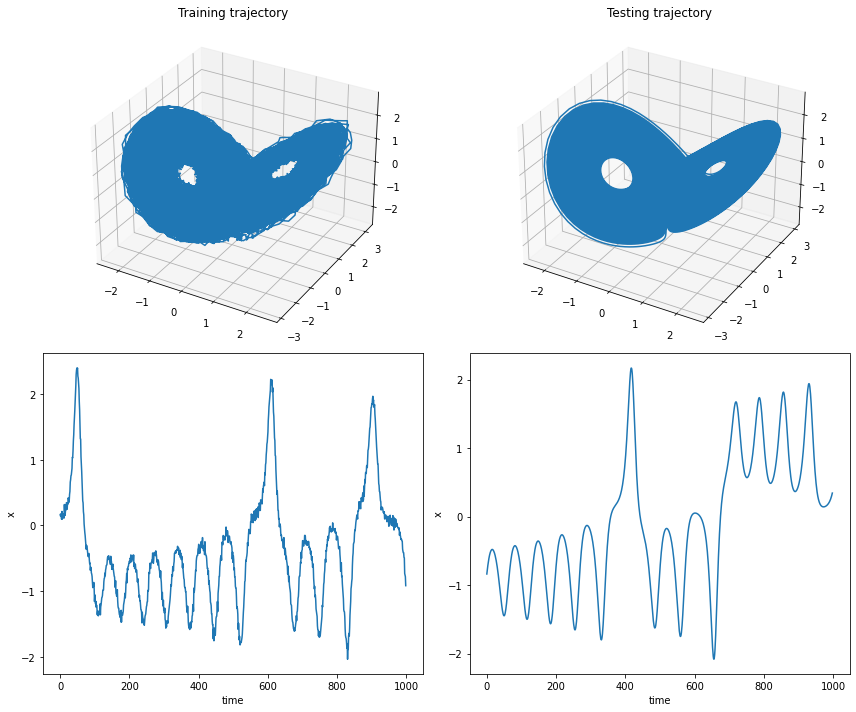

In [5]:
# visualize
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(221, projection='3d')
ax1.plot3D(X_train[:, 0], X_train[:, 1], X_train[:, 2])
ax1.set_title('Training trajectory')

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot3D(X_test[:, 0], X_test[:, 1], X_test[:, 2])
ax2.set_title('Testing trajectory')

ax3 = fig.add_subplot(223)
ax3.plot(X_train[1:1000, 0])
ax3.set_xlabel("time")
ax3.set_ylabel("x")

ax4 = fig.add_subplot(224)
ax4.plot(X_test[1:1000, 0])
ax4.set_xlabel("time")
ax4.set_ylabel("x")

plt.tight_layout()
plt.show()

## 3 The model
The model we use to reconstruct the Lorenz63 attractor is the shallowPLRNN with state equation


$$
\mathbf{z}_t = \mathbf{F}_\mathbf{\theta}(\mathbf{z}_{t-1}) = \mathbf{A}\mathbf{z}_{t-1} + \mathbf{W}_1 \textrm{ReLU}(\mathbf{W}_2\mathbf{z}_{t-1}+\mathbf{h}_2) + \mathbf{h}_1 + \mathbf{C}\mathbf{s}_t
$$


with state $\mathbf{z}_t \in \mathbb{R}^M$, external inputs $\mathbf{s}_t \in \mathbb{R}^K$ and parameters $\mathbf{A} \in \mathbb{R}^{M \times M}$ (diagonal), $\mathbf{W}_1 \in \mathbb{R}^{M \times L}$, $\mathbf{W}_2 \in \mathbb{R}^{L \times M}$, $\mathbf{h}_1 \in \mathbb{R}^M$, $\mathbf{h}_2 \in \mathbb{R}^L$, $\mathbf{C} \in \mathbb{R}^{M \times K}$ and of course $\textrm{ReLU}(\cdot) = \max(0, \cdot)$ being the rectified linear unit. The model Jacobian has an easy form, which allows straigh-forward implementation and is useful to speed up e.g. the computation of the Lyapunov spectrum.

We do not assume an additional observation model, i.e. we train the model directly on the observed data ($\mathbf{x}_t = \mathbf{I}\mathbf{z}_t = \mathbf{z}_t$).

The Lorenz63 system is autonomous, hence we omit the term $\mathbf{C}\mathbf{s}_t$ in that case. If you have a dataset with external inputs however, feel free to use it.

[HINT: If you have external inputs at your disposal, make sure there are in a $T \times K$ format].

In [6]:
class shallowPLRNN(nn.Module):
    def __init__(self, M, L, K=0):
        super(shallowPLRNN, self).__init__()
        self.M = M
        self.L = L
        self.K = K
        self.autonomous = False
        if K == 0:
            self.autonomous = True
        self.init_parameters()

    def init_parameters(self):
        r1 = 1.0 / (self.L ** 0.5)
        r2 = 1.0 / (self.M ** 0.5)
        self.W1 = nn.Parameter(uniform_(torch.empty(self.M, self.L), -r1, r1))
        self.W2 = nn.Parameter(uniform_(torch.empty(self.L, self.M), -r2, r2))
        self.A = nn.Parameter(uniform_(torch.empty(self.M), a=0.5, b=0.9))
        self.h2 = nn.Parameter(uniform_(torch.empty(self.L), -r1, r1))
        self.h1 = nn.Parameter(torch.zeros(self.M))
        if self.autonomous:
            self.C = None
        else:
            r3 = 1.0 / (self.K ** 0.5)
            self.C = nn.Parameter(uniform_(torch.empty(self.M, self.K), -r3, r3))

    def forward(self, z):
        #return self.A * z + torch.relu(z @ self.W2.T + self.h2) @ self.W1.T + self.h1
        return self.A * z + self.W1@torch.relu(self.W2@z + self.h2) + self.h1

    def jacobian(self, z):
        """Compute the Jacobian of the model at state z. Expects z to be a 1D tensor."""
        #assert z.ndim() == 1
        return torch.diag(self.A) + self.W1 @ torch.diag(self.W2 @ z > -self.h2).float() @ self.W2

    def ext_input(self, s):
        if self.autonomous or s is None:
            return 0
        elif self.autonomous and s is not None:
            raise ValueError('Model was initialized as autonomous!')
        else:
            return s @ self.C.T

    def __call__(self, z, s=None):
        """
        Compute the next state of the model. Expects `z` and `s` to be a 2D tensor
        where the first dimension is the batch dimension.
        """
        return self.forward(z) + self.ext_input(s)

@torch.no_grad()
def generate_orbit(model, z1, T, S=None):
    """
    Generate an orbit of `model`, i.e. starting from initial condition `z1`, draw
    a trajectory of length `T` with optional external input matrix `S` of shape
    `T x K`.
    """
    if S is None:
        S = [None] * T

    z = z1
    orbit = [z]
    for t in range(T):
        z = model(z, S[t])
        orbit.append(z)
    return torch.stack(orbit)


In [7]:
# load pretrained model
model = shallowPLRNN(M=3, L=50, K=0)
model.load_state_dict(torch.load("pretrained-shPLRNN.pt"))

<All keys matched successfully>

## 4 Exact finding of all fixed points in shPLRNN

Alternatively, we can exploit the fact that the dynamics are constrained to an $M$ dimensional space. We first find all the possible subspaces in which dynamics are linear and inside the M dimensional space, and then solve for the fixed points in each of those subspaces.
Also see fixed_points_in_shRNNs.pdf in this repo (this includes a Figures that helps illustrate the method)

#### Main result
We can obtain all fixed points of a shPLRNN, by solving ${L \choose m}+\sum^M_{m=0}{L \choose m}$ linear systems of $M$ equations

#### If M < L, not all configurations of D can be reached

First, define $\mathbf{x}_t \in \mathcal{R}^L$ as $\mathbf{x}_t=\mathbf{W}_2\mathbf{z}_t$, such that $\mathbf{z}_t$ can be seen as the projection of $\mathbf{x}_t$ on $\mathbf{W}_2$:, $\mathbf{z}_t= (\mathbf{W}_2^\mathsf{T}\mathbf{W}_2)^{-1}\mathbf{W}_2^\mathsf{T}\mathbf{x}$.

To get some intuition, consider $M=1, L=2$. The phase space of the model can be broken up in 4 subspaces, each corresponding to one configuration of $\mathbf{D}$. The dynamics are however confined to the line spanned by the vector $\mathbf{W}_2$ (with coordinate $z$), which can reach at most 3 of the subspaces. 

We can solve for the points where $\mathbf{W}_2$ crosses a border between subspaces. E.g. for border given by $\mathbf{x}_1 = -\mathbf{h}^{(2)}_1$, we have $\begin{bmatrix}\mathbf{x}_1\\ \mathbf{x}_2\end{bmatrix} = z\begin{bmatrix}\mathbf{u}_1\\ \mathbf{u}_2\end{bmatrix}=-\begin{bmatrix}\mathbf{h}^{(2)}_1\\0\end{bmatrix}$, thus this border crosses $\mathbf{u}$ at $z=-\frac{\mathbf{h}^{(2)}_1}{\mathbf{u}_1}$ 

In general, for networks with $M=1$, each neuron adds 1 point to the line along which the dynamics flow (at $z=-\frac{\mathbf{h}^{(2)}_i}{\mathbf{u}_i}$ for the i'th neuron), meaning we can reach at most $L+1$ subspaces / configurations of $\mathbf{D}$. We only have to solve $L+1$ 'matrix' inverses to find all inverses!

For $M=2$ dynamics are confined to a plane, spanned by the two columns of $\mathbf{W}_2$, and each neuron adds a line to this plane. The amount of configurations of $\mathbf{D}$ we can reach is thus equal to the question, in how many surfaces can we divide a plane with $L$ lines, which is $\frac{1}{2}(L^2+L)+1$ --- a big improvement over $2^L$.

Generalising this to arbitrary $M$, we have to answer the question, in how many subspaces can we divide an $M$ dimensional space with $L$ hyperplanes, which has the solution $\sum^M_{m=0}{L \choose m}$



#### Finding all reachable configurations of D
We so far showed that we only need to consider $\sum^M_{m=0}{L \choose m}$ configurations of $\mathbf{D}$, but how do we find these configurations?. First we can solve for all cross sections of hyperplanes (see previous section for r=1). To do this, we have to solve ${L \choose M}$ systems of linear equations. 

Each cross section borders $2^M$ subregions. We can find the corresponding $\mathbf{D}$ matrices of each of those subsection as follows. First compute $\mathbf{x=W}_2\mathbf{z}$, corresponding to the cross section we are currently considering. Next calculate all the $\mathbf{D}$ 's corresponding to the found $\mathbf{x}$ --- for elements $\mathbf{x}_i$ of $\mathbf{x}$ which are equal to $-\mathbf{h}^{(2)}_i$, $\mathbf{D}_i$ can be either 1, or 0. Now we just make a list of all possible $\mathbf{D}$ 's that we find this way, and finally remove any duplicates.




In [8]:
from itertools import combinations, chain
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s,r) for r in range(len(s)+1))

def find_fixed_points(model):
    #get parameters
    a = model.A.detach().numpy()
    V=model.W1.detach().numpy().T
    U=model.W2.detach().numpy()
    hz = model.h1.detach().numpy()
    h  = model.h2.detach().numpy()

    N=U.shape[0]
    R=U.shape[1]

    # First solve for all intersection of hyperplanes
    intersect_inds = np.array(list(combinations(np.arange(N),R)))
    print(len(intersect_inds))
    n_Ds_initial = len(list(powerset(range(R))))*len(intersect_inds)
    print(len(list(powerset(range(R)))))
    D_list = np.zeros((n_Ds_initial,N),dtype='uint8')
    it = 0
    for inds in intersect_inds:
        b_hat = h[inds]
        U_hat = U[inds]
        z = np.linalg.solve(U_hat,-b_hat)
        
        # Find all subspaces bordering to this intersection
        x = U@z+h
        D_init = np.array(x > 0).astype('uint8')
        D_init[inds]=0
        D_list[it]=D_init
        it+=1
        D_inds = list(powerset(inds))[1:]
        for D_ind in D_inds:
            D=np.copy(D_init)
            D[np.array(D_ind)]=1
            D_list[it]=D
            it+=1


    # Throw away duplicate subspaces
    print(D_list.shape)
    D_list = np.unique(D_list,axis=0)
    print(D_list.shape)

    # Finally solve for fixed points
    z_list = []
    D_inds = []
    for D_ind,D_init in enumerate(D_list):

        A = np.eye(R)-np.diag(a)-V.T@np.diag(D_init)@U
        b = V.T@np.diag(D_init)@h+hz
        z_hat = np.linalg.solve(A,b)
        x_hat = U@z_hat+h
        if np.allclose(D_init,np.array(x_hat > 0).astype('uint8')):
            print("Found a fixed point")
            print(z_hat)
            z_list.append(z_hat)
            D_inds.append(D_ind)
    print("Done, found " + str(len(z_list)) + " fixed points")
    return D_list,D_inds,z_list
D_list,D_inds,z_list=find_fixed_points(model)

19600
8
(156800, 50)
(20876, 50)
Found a fixed point
[1.16843305 1.03046877 0.49788019]
Found a fixed point
[-0.96366281 -0.85881832  0.37466785]
Found a fixed point
[ 0.07166251  0.0815779  -2.58943793]
Done, found 3 fixed points


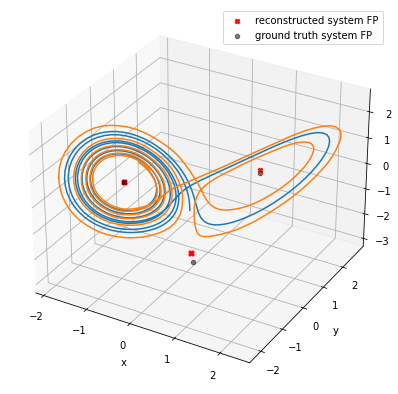

In [9]:
ax = plt.figure(figsize=(12, 7)).add_subplot(projection='3d')
t_plot = 600
# lets draw an orbit of the system
x1 = torch.tensor(X_test[0, :])
orbit = generate_orbit(model, x1, T_test).numpy()
ax.plot(X_test[:t_plot, 0], X_test[:t_plot, 1], X_test[:t_plot, 2])
ax.plot(orbit[:t_plot, 0], orbit[:t_plot, 1], orbit[:t_plot, 2])

# Scatter plot for FP
ax.scatter(z_list[0][0],z_list[0][1],z_list[0][2],marker="X",c="red",label="reconstructed system FP")
ax.scatter(z_list[1][0],z_list[1][1],z_list[1][2],marker="X",s=30,c="red")
ax.scatter(z_list[2][0],z_list[2][1],z_list[2][2], marker="X",s=30,c="red")


# Scatter plot for ground truth points
true_FPs = np.load("lorenz63_standardized_FPs.npy")
ax.scatter(true_FPs[0, 0], true_FPs[1, 0], true_FPs[2, 0], c="black",label="ground truth system FP",alpha=.5)
ax.scatter(true_FPs[0, 1], true_FPs[1, 1], true_FPs[2, 1], c="black",alpha=.5)
ax.scatter(true_FPs[0, 2], true_FPs[1, 2], true_FPs[2, 2], c="black",alpha=.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend()
plt.show()